+++
title = "Predictive asymmetry"
subtitle = ""
date = 2019-04-15T00:00:00
lastmod = 2019-04-15T00:00:00
draft = false

# Authors. Comma separated list, e.g. `["Bob Smith", "David Jones"]`.
authors = ["Kristian A. Haaga", "David Diego", "Bjarte Hannisdal"]

tags = []
summary = "A simple and robust test for causal directionality in complex systems."

# Projects (optional).
#   Associate this post with one or more of your projects.
#   Simply enter your project's folder or file name without extension.
#   E.g. `projects = ["deep-learning"]` references
#   `content/project/deep-learning/index.md`.
#   Otherwise, set `projects = []`.
# projects = ["asymmetrytest"]
+++


## A brief tutorial on the predictive asymmetry test

Here's an example of how to compute the remarkable predictive asymmetry test of causality from time series proposed by Haaga *et al.* (forthcoming). The ``jupyter`` notebook was run using Julia 1.2 with our package <a href=https://www.earthsystemevolution.com/project/causalitytools/>``CausalityTools.jl``</a>. 

Let's start by importing the necessary functions. 

In [2]:
using CausalityTools, UncertainData
using StatsBase # statistical functions, e.g. mean
using Distributions # probability distributions
using Plots; pyplot() # use pyplot backend
using LaTeXStrings # enable TeX i pyplot

## Some example data

Let's create some example data with three dynamical variables coupled $x \to y \to z$.

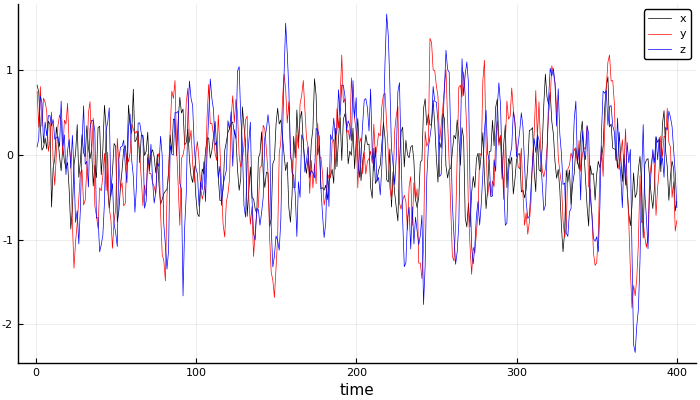

In [49]:
npts = 400
y = rand(npts, 3) 


N = Normal(0, 1)

a₁, a₂ = 0.7, 0.1
b₁, b₂ = 0.75, 0.2
c₁, c₂ = 0.6, 0.2
C₁₂, C₂₃ = 0.5, 0.5
ξ₁, ξ₂, ξ₃ = 0.3, 0.3, 0.3

for t in 5:npts
    y[t,1] = a₁*y[t-1,1] - a₂*y[t-4,1] +                ξ₁*rand(N)
    y[t,2] = b₁*y[t-1,2] - b₂*y[t-4,2] + C₁₂*y[t-1,1] + ξ₂*rand(N)
    y[t,3] = c₁*y[t-1,3] - c₂*y[t-3,3] + C₂₃*y[t-1,2] + ξ₃*rand(N)
end

x, y, z = [y[:, i] for i = 1:3]
labs = "x", "y", "z"

plot(1:npts, x, c = :black, label = "x", lw = .5, 
    xlabel = "time", ylabel = "", size = (700, 400))
plot!(1:npts, y, c = :red, label = "y", lw = .5)
plot!(1:npts, z, c = :blue, label = "z", lw = .5)


## Predictive asymmetry test for causality

Now, we'll try to see if we can recover the unidirectional relationships using the predictive asymmetry test. To compute the predictive asymmetry, we'll use the transfer operator grid (Diego et al., 2019) transfer entropy test. To understand the parameters of the test, we need some background on transfer entropy:

### Transfer entropy

Let's say we have a source time series $S$ and a target time series $T$. For convenience, define

$$ \begin{align} T_f^{(k)} &= \{(T(t+\eta_k), \ldots, T(t+\eta_2), T(t+\eta_1))\}, \label{eq:Tf} \\ T_{pp}^{(l)} &= \{ (T(t), T(t-\tau_1), T(t-\tau_2), \ldots, T(t - \tau_{l - 1})) \\ S_{pp}^{(m)} &= \{(S(t), S(t-\tau_1), S(t-\tau_2), \ldots, S(t-\tau_{m - 1}))\} \end{align} $$

Combining into a generalised delay reconstruction: 

$$ \begin{align} \mathbb{E} = (T_f^{(k)}, T_{pp}^{(l)}, S_{pp}^{(m)}) \end{align} $$

With that, we have an embedding that we can use to compute transfer entropy:

$$ \begin{align} TE_{S \rightarrow T} = \int_{\mathbb{E}} P(T_f, T_{pp}, S_{pp}) \log_{2}{\left(\frac{P(T_f | T_{pp}, S_{pp})}{P(T_f | T_{pp})}\right)} \end{align} $$.

### Deciding on test parameters

To organise our test, we can create an instance of a `TransferOperatorGridTest`, which has the following signature:

```julia
TransferOperatorGridTest(k::Int = 1, l::Int = 1, m::Int = 1, n::Int = 1, 
    τ::Int = 1, b = 2, estimator::TransferOperatorGrid = TransferOperatorGrid(), 
    binning_summary_statistic::Function = StatsBase.mean,
    binning::RectangularBinning, ηs)
```

To get the full documentation, type `?TransferOperatorGridTest`. 

#### Parameter list

What's important for us are
 
- `k`, `l`, and `m`, which dictate the dimension of the delay reconstruction. 
- The `binning`, which is a `RectangularBinning` instance.
- `ηs` is/are the prediction lag(s).
- `b` is the base of the logarithm.
- The `τ` parameter is the reconstruction delay, which only matters for `k + l + m > 3`. 

With that in mind, let's set up a very simple test.

In [50]:
# Use a three-dimensional delay reconstruction
k, l, m = 1, 1, 1

# Use a rectangular partition where the number of bin elements scale 
# with the number of points (following Krakovska et al., 2018).
n_subdivisions = floor(Int, npts^(1/(k+l+m+1)))
binning = RectangularBinning(n_subdivisions)

# Compute the predictive asymmetry for η ranging from -8 to 8.
ηs = -8:8

te_test = TransferOperatorGridTest(k = k, l = l, m = m, binning = binning, ηs = ηs)

TransferOperatorGridTest(k = 1, l = 1, m = 1, n = 1, τ = 1, b = 2, estimator = TransferOperatorGrid(), binning_summary_statistic = mean, binning = RectangularBinning(4), ηs = -8:8)

Now, we can use this transfer entropy test as input to a `PredictiveAsymmetryTest` instance.

In [51]:
pa_test = PredictiveAsymmetryTest(predictive_test = te_test)

PredictiveAsymmetryTest{TransferOperatorGridTest}(predictive_test = TransferOperatorGridTest(k = 1, l = 1, m = 1, n = 1, τ = 1, b = 2, estimator = TransferOperatorGrid(), binning_summary_statistic = mean, binning = RectangularBinning(4), ηs = -8:8))

## Applying the test

In [52]:
pa_xy = causality(x, y, pa_test)
pa_yx = causality(y, x, pa_test)
pa_yz = causality(y, z, pa_test)
pa_zy = causality(z, y, pa_test)
pa_xz = causality(x, z, pa_test)
pa_zx = causality(z, x, pa_test);

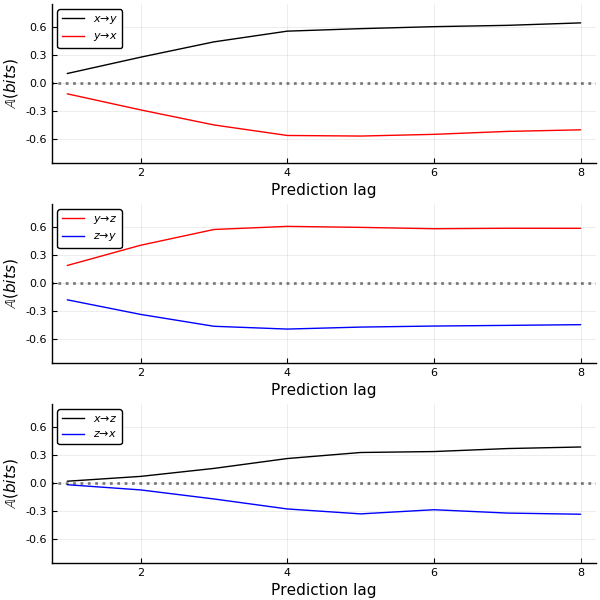

In [68]:
p_xy = plot(xlabel = "Prediction lag", ylabel = L"\mathbb{A} (bits)",
    ylims = [-0.8, 0.8])
plot!(1:maximum(ηs), pa_xy, label = L"x \to y", c = :black)
plot!(1:maximum(ηs), pa_yx, label = L"y \to x", c = :red)
hline!([0], lw = 2, ls = :dot, α = 0.5, c = :black, label = "")

p_yz = plot(xlabel = "Prediction lag", ylabel = L"\mathbb{A} (bits)",
    ylims = [-0.8, 0.8])
plot!(1:maximum(ηs), pa_yz, label = L"y \to z", c = :red)
plot!(1:maximum(ηs), pa_zy, label = L"z \to y", c = :blue)
hline!([0], lw = 2, ls = :dot, α = 0.5, c = :black, label = "")

p_xz = plot(xlabel = "Prediction lag", ylabel = L"\mathbb{A} (bits)",
    ylims = [-0.8, 0.8])
plot!(1:maximum(ηs), pa_xz, label = L"x \to z", c = :black)
plot!(1:maximum(ηs), pa_zx, label = L"z \to x", c = :blue)
hline!([0], lw = 2, ls = :dot, α = 0.5, c = :black, label = "")

plot(p_xy, p_yz, p_xz, layout = grid(3, 1), size = (600, 600), legend = :topleft)

The direct influences $\mathbb{A}_{x \to y}$ and $\mathbb{A}_{y \to z}$ are both positive and of equal strength, while the indirect influence $\mathbb{A}_{x \to z}$ is weaker. In the non-causal direction, $\mathbb{A}_{y \to x}$, $\mathbb{A}_{z \to y}$ and $\mathbb{A}_{z \to x}$ are all negative. We thus recover the underlying directionality and relative strength of couplings.